Event Synchronization Analysis following 
https://github.com/pik-copan/pyunicorn/blob/master/tests/test_funcnet/TestEventSyncronization.py
and 
https://vis.caltech.edu/~rodri/papers/event_synchro.pdf

In [1]:
import sys, string
from matplotlib import rc
import numpy as np
import pylab as pl
import netCDF4
import time as t
import datetime
from dateutil.parser import parse
from pylab import load, meshgrid, title, arange, show
from netcdftime import utime
import scipy.io
import matplotlib as mpl
import argparse
from matplotlib.dates import MonthLocator, WeekdayLocator, DateFormatter
import datetime as dt
from netCDF4 import num2date, date2num
import random
#import Nio
#from pyhdf.SD import SD

In [12]:
N=10000
Q_real = np.genfromtxt ('data/Q_histreal.csv', delimiter=",")
Q_hist_mc = np.zeros((N,Q_real.shape[0]))
#print(Q_real.shape)
for i in range(1,10001):
    #print(i)
    Q_hist_mc[i-1,:] = np.genfromtxt ('data/Q_hist'+str(i)+'.csv', delimiter=",")

In [18]:
volc_sigl = -1*np.genfromtxt ('sigl.txt', delimiter=",")

volc_data = volc_sigl[1:997]
volc_data_mon = np.zeros((997*12))
volc_data_mon[0:6] = volc_data[0]
volc_data_mon[11958:11964] = volc_data[-1]
for yyyy in range(995):
    #print(yyyy)
    volc_data_mon[6+yyyy*12:18+yyyy*12] = volc_data[1+yyyy]

volc_data_mon_ma = np.zeros((volc_data_mon.shape[0]-60))
for i in range(volc_data_mon.shape[0]-60):
    volc_data_mon_ma[i] = np.average(volc_data_mon[i:i+60])


In [23]:
def common_time_axis(dismr, verbose=True):
    """
    Generates common time axis for Nino3 and ISMR time series.
    """
    # generate the time axis
    Nt = len(dismr)
    time = [dt.datetime(854, 1, 15)]
    for i in range(1, len(dismr)):
        y = time[i - 1].year
        m = time[i - 1].month
        if m == 12:
            y += 1
            m = 0
        time.append(dt.datetime(y, m + 1, 15))
    time = np.array(time)

    return time
time = common_time_axis(Q_real)


In [24]:
np.savetxt('Q_hist_mc.csv', Q_hist_mc, delimiter=',')

In [28]:
Q_hist_mc_95p = np.zeros((Q_real.shape[0]))
for i in range(Q_hist_mc_95p.shape[0]):
    Q_hist_mc_95p[i] = np.percentile(Q_hist_mc[:,i], 95)

In [33]:
def delphi_timeseries(time, Q_hist_real, Q_hist_mc_95p, volc_data_mon_ma):
    """
    Plots the instantaneous phase diff with periods of phase sync highlighted.
    """
    # set up figure
    fig = pl.figure(figsize=[12, 9])
    #fig = pl.figure(figsize=[4, 3])
    #axlabfs, tiklabfs, splabfs = 9, 10, 14
    axlabfs, tiklabfs, splabfs = 4, 5, 7
    start_year = 850
    end_year = 1849

    # set up ax1 and plot delPhi and event series there
    ax1 = fig.add_axes([0.1, 0.28, 0.85, 0.4])
    #ax1.plot(ct, -del_phi/6.28,
    #         c="Maroon", zorder=5,
    #         )
    ylo, yhi = ax1.get_ylim()
    # set up second ax2 and plot the volcanic radiative forcing 
    ax2 = fig.add_axes([0.1, 0.18, 0.85, 0.1])
    #ax3 = fig.add_axes([0.1, 0.66, 0.85, 0.15])
    ax2.plot(time, volc_data_mon_ma, c="Gray", zorder=5)
    #ax3.plot(pt, plv, pt, plv_99p)
    ax1.plot(time, Q_hist_real, time, Q_hist_mc_95p)

    ylo, yhi = ax1.get_ylim()
    xlo, xhi = dt.datetime(start_year, 1, 1), dt.datetime(end_year, 12, 31)
    ax1.set_xlim(xlo, xhi)
    XMajorLocator = mdates.YearLocator(base=100, month=6, day=15)
    XMinorLocator = mdates.YearLocator(base=20, month=6, day=15)
    XMajorFormatter = mdates.DateFormatter("%Y")
    ax1.xaxis.set_major_locator(XMajorLocator)
    ax1.xaxis.set_minor_locator(XMinorLocator)
    ax1.xaxis.set_major_formatter(XMajorFormatter)
    ax1.set_ylim(ylo, yhi)
    ax1.set_xticklabels([])
    #ax1.set_ylim(-12,12 )
    ax1.grid(which="both")
    ax1.tick_params(which="major", size=8, direction="out")
    ax1.tick_params(which="minor", size=5, direction="out")
    ax1.tick_params(axis="both", labelsize=tiklabfs)
#    ax1.set_xlabel("Time", fontsize=axlabfs)
    #ax1.set_ylabel(r"$\Delta\phi = \phi_{ISMR} - \phi_{NINO}[2\pi]$",fontsize=axlabfs)


    # prettify ax2
    xlo, xhi = dt.datetime(start_year, 1, 1), dt.datetime(end_year, 12, 31)
    ax2.set_xlim(xlo, xhi)
    XMajorLocator = mdates.YearLocator(base=100, month=6, day=15)
    XMinorLocator = mdates.YearLocator(base=20, month=6, day=15)
    XMajorFormatter = mdates.DateFormatter("%Y")
    ax2.xaxis.set_major_locator(XMajorLocator)
    ax2.xaxis.set_minor_locator(XMinorLocator)
    ax2.xaxis.set_major_formatter(XMajorFormatter)
    ylo, yhi = ax2.get_ylim()
    ax2.set_ylim(ylo, yhi)
    ax2.tick_params(axis="both", labelsize=tiklabfs)
    ax2.grid(which="both")
    ax2.set_xlabel("Time", fontsize=axlabfs)
    ax2.set_ylabel("VRF (W/$m^2$)", fontsize=axlabfs)
    # save figure
    #figname = "../plots/02_delphi_timeseries.eps"
    figname = "test.png"
    #pl.savefig(figname, format='eps', dpi=1000)
    pl.savefig(figname, format='png', dpi=1000)
    print("figure saved to: %s" % figname)
    return None



figure saved to: test.png


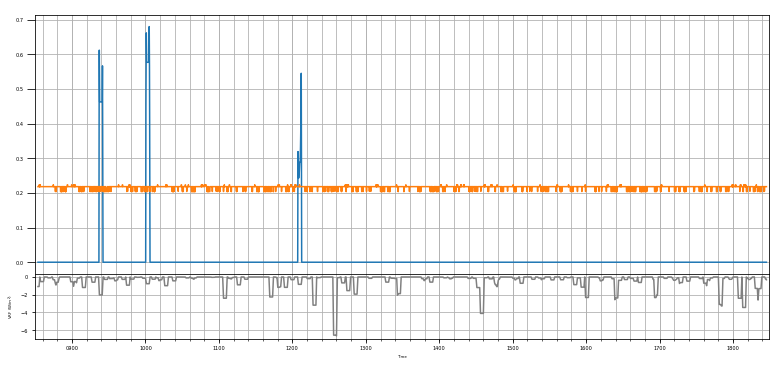

In [37]:
import matplotlib.dates as mdates
delphi_timeseries(time, Q_real, Q_hist_mc_95p, -volc_data_mon_ma )